# Import of the libraries

In [48]:
import optuna
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import tqdm
from sklearn.metrics import roc_curve, auc

# We run the code in GPU using cuda

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dimensionality = [9, 12, 15, 18]

Using device: cuda


# Definition of NN model

In [50]:
class DynamicNeuralNetwork(torch.nn.Module):
    def __init__(self, dim, hidden_sizes, dropout_rate):
        super(DynamicNeuralNetwork, self).__init__()
        layers = []
        last_size = dim

        for size in hidden_sizes:
            layers.append(torch.nn.Linear(last_size, size))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_rate))
            last_size = size

        layers.append(torch.nn.Linear(last_size, 1))
        layers.append(torch.nn.Sigmoid())
        self.network = torch.nn.Sequential(*layers)

        # Initialize weights, based on https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_init_weights.py
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        return self.network(x)

# Pre-processing and data loaders defintion

In [51]:
def denoise_bernoulli_data(X):
    """Denoise data by converting to binary values"""
    return (X >= 0.5).astype(float)

In [52]:
def create_dataloaders(X, y, batch_size):
    """Convert numpy arrays to PyTorch tensors and create DataLoaders."""
    X = denoise_bernoulli_data(X)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return loader

# Function that spcifies how the model is trained

In [53]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device, early_stopping_patience=50, print_statements=False):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    best_val_loss = float('inf')
    for epoch in tqdm.tqdm(range(num_epochs)):
        # Train Model
        model.to(device)
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs >= 0.5).float()
            train_correct += (predicted == labels.unsqueeze(1)).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total * 100
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels.unsqueeze(1).float())
                
                val_loss += loss.item()

                # Calculate accuracy
                predicted = (outputs >= 0.5).float()
                val_correct += (predicted == labels.unsqueeze(1)).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1


        if patience_counter >= early_stopping_patience and print_statements:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        if (epoch + 1) % 10 == 0 and print_statements:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return model, best_val_loss, train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation of the trained model using test loader definition

In [54]:
def evaluate_model(model, dim, test_loader, save_file):
	model.eval()
	all_preds = []
	all_labels = []
    
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs = inputs.view(inputs.size(0), -1)
			outputs = model(inputs)
			predictions = (outputs >= 0.5).float().cpu().numpy()
			all_preds.extend(predictions)
			all_labels.extend(labels.cpu().numpy())
    
	all_preds = np.array(all_preds).squeeze()
	print(all_preds)
	
	if save_file:    
		all_labels = np.array(all_labels)
		np.save(f'kryptonite_{dim}_pred_nn.npy', all_preds)

	return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds)
    }

# Functions to get predictions

- get_predictions is mostly used for the model evaluation.
- get_predictions_final is used for the predictions on the hidden data.
- get_predictions_prob is used to get the probability for the sigmoid link function. This is used for the AUC graph and ROC scores.

In [55]:
def get_predictions(model, test_loader):
	model.eval()
	all_preds = []
	all_labels = []
    
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs = inputs.view(inputs.size(0), -1)
			outputs = model(inputs).float().cpu().numpy()
			predictions = (outputs >= 0.5).float().cpu().numpy()
			all_preds.extend(predictions)
			all_labels.extend(labels.cpu().numpy())

	all_preds = np.array(all_preds).squeeze()
	print(all_preds)

	return {
		'all_predictions': all_preds,
		'all_labels': all_labels
    }

In [56]:
def get_predictions_final(model, test_loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        all_inputs = [batch[0].to(device) for batch in test_loader]
        all_inputs = torch.cat(all_inputs, dim=0)
        outputs = model(all_inputs).float().cpu().numpy()
        predictions = (outputs >= 0.5).astype(float)
        all_preds.extend(predictions)

    all_preds = np.array(all_preds).squeeze()
    print(all_preds)

    return {
        'all_predictions': all_preds
    }


In [57]:
def get_predictions_prob(model, test_loader):
	model.eval()
	all_preds = []
	all_labels = []

	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs = inputs.view(inputs.size(0), -1)
			outputs = model(inputs).float().cpu().numpy()
			all_preds.extend(outputs)
			all_labels.extend(labels.cpu().numpy())
    
	all_preds = np.array(all_preds).squeeze()
	print(all_preds)

	return {
		'all_predictions': all_preds,
		'all_labels': all_labels
    }

# Defintion of cross validation function

In [68]:
def k_fold_cross_validation(X, y, best_params, dim, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        train_loader = create_dataloaders(X_train, y_train, best_params['batch_size'])
        val_loader = create_dataloaders(X_test, y_test, best_params['batch_size'])

        model = DynamicNeuralNetwork(dim, best_params['hidden_sizes'], 0.15).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=0.0001)
        loss_fn = torch.nn.BCELoss()

        trained_model, _, _, _, _, _ = train_model(model, train_loader, val_loader, loss_fn, optimizer, 100, device)
        results.append(evaluate_model(trained_model, dim, val_loader, False))

    metric_names = ['accuracy', 'precision', 'recall', 'f1']
    avg_metrics = {
        metric: np.mean([result[metric] for result in results])
        for metric in metric_names
    }
    
    std_metrics = {
        metric: np.std([result[metric] for result in results])
        for metric in metric_names
    }
    
    print("\nAverage Results Across All Folds:")
    for metric in metric_names:
        print(f"{metric.capitalize()}: {avg_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")
    
    return avg_metrics, std_metrics

# Defintion of the objective function we minize in the Optuna framework

This function is used to find the best hyper paramters (it performs the hyper parameter search)

In [59]:
def objective(trial, dim):
	X_train = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-X_train.npy')
	y_train = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-y_train.npy')

	X_train = denoise_bernoulli_data(X_train)

	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

	batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
	learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, step=0.001)
	weight_decay = 0.0001
	dropout_rate = 0.15
	num_layers = trial.suggest_int('num_layers', 2, 4)
	hidden_sizes = [trial.suggest_categorical(f'hidden_size_l{i}', [64, 128, 256]) for i in range(num_layers)]
	num_epochs = 200

	train_loader = create_dataloaders(X_train, y_train, batch_size)
	val_loader = create_dataloaders(X_val, y_val, batch_size)
	model = DynamicNeuralNetwork(dim, hidden_sizes=hidden_sizes, dropout_rate=dropout_rate).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	loss_fn = torch.nn.BCELoss()
	_, _, _, val_losses, _, _ = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device)

	return val_losses[-1]

In [60]:
best_params_by_dim = []

for dim in dimensionality:
	print(f"-=-=-=-= Running Dimension: {dim} =-=-=-=-")

	study = optuna.create_study(direction='minimize')
	study.optimize(lambda trial: objective(trial, dim), n_trials=10)

	print("Best trial:")
	trial = study.best_trial

	print(f"  Value: {trial.value}")
	print("  Params: ")

	for key, value in trial.params.items():
		print(f"    {key}: {value}")

	best_params = trial.params
	best_params['hidden_sizes'] = [best_params.pop(f'hidden_size_l{i}') for i in range(best_params['num_layers'])]

	del best_params['num_layers']
	best_params_by_dim.append(best_params)

[I 2024-11-25 19:24:42,154] A new study created in memory with name: no-name-c55a10c5-b721-4903-ae7b-f3d4856a91a4


-=-=-=-= Running Dimension: 9 =-=-=-=-


100%|██████████| 200/200 [07:50<00:00,  2.35s/it]
[I 2024-11-25 19:32:33,015] Trial 0 finished with value: 0.15686007841593688 and parameters: {'batch_size': 16, 'learning_rate': 0.0041, 'num_layers': 4, 'hidden_size_l0': 128, 'hidden_size_l1': 64, 'hidden_size_l2': 64, 'hidden_size_l3': 256}. Best is trial 0 with value: 0.15686007841593688.
100%|██████████| 200/200 [02:07<00:00,  1.57it/s]
[I 2024-11-25 19:34:40,426] Trial 1 finished with value: 0.1542335910929574 and parameters: {'batch_size': 64, 'learning_rate': 0.0071, 'num_layers': 3, 'hidden_size_l0': 256, 'hidden_size_l1': 64, 'hidden_size_l2': 128}. Best is trial 1 with value: 0.1542335910929574.
100%|██████████| 200/200 [03:39<00:00,  1.10s/it]
[I 2024-11-25 19:38:19,849] Trial 2 finished with value: 0.15399034511711862 and parameters: {'batch_size': 32, 'learning_rate': 0.0021, 'num_layers': 3, 'hidden_size_l0': 64, 'hidden_size_l1': 256, 'hidden_size_l2': 128}. Best is trial 2 with value: 0.15399034511711862.
100%|█████████

Best trial:
  Value: 0.15195266073569655
  Params: 
    batch_size: 16
    learning_rate: 0.0011
    num_layers: 4
    hidden_size_l0: 128
    hidden_size_l1: 128
    hidden_size_l2: 64
    hidden_size_l3: 64
-=-=-=-= Running Dimension: 12 =-=-=-=-


100%|██████████| 200/200 [05:07<00:00,  1.54s/it]
[I 2024-11-25 20:05:12,595] Trial 0 finished with value: 0.20413752653015158 and parameters: {'batch_size': 32, 'learning_rate': 0.0011, 'num_layers': 3, 'hidden_size_l0': 256, 'hidden_size_l1': 256, 'hidden_size_l2': 256}. Best is trial 0 with value: 0.20413752653015158.
100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2024-11-25 20:09:35,860] Trial 1 finished with value: 0.1746273993048817 and parameters: {'batch_size': 32, 'learning_rate': 0.0021, 'num_layers': 2, 'hidden_size_l0': 256, 'hidden_size_l1': 64}. Best is trial 1 with value: 0.1746273993048817.
100%|██████████| 200/200 [02:58<00:00,  1.12it/s]
[I 2024-11-25 20:12:34,490] Trial 2 finished with value: 0.6931205729643504 and parameters: {'batch_size': 64, 'learning_rate': 0.0071, 'num_layers': 4, 'hidden_size_l0': 256, 'hidden_size_l1': 64, 'hidden_size_l2': 64, 'hidden_size_l3': 256}. Best is trial 1 with value: 0.1746273993048817.
100%|██████████| 200/200 [07:58<00:00,

Best trial:
  Value: 0.16446561724878847
  Params: 
    batch_size: 32
    learning_rate: 0.0011
    num_layers: 2
    hidden_size_l0: 64
    hidden_size_l1: 128
-=-=-=-= Running Dimension: 15 =-=-=-=-


100%|██████████| 200/200 [03:29<00:00,  1.05s/it]
[I 2024-11-25 20:51:01,787] Trial 0 finished with value: 0.19241337110598883 and parameters: {'batch_size': 64, 'learning_rate': 0.0031, 'num_layers': 3, 'hidden_size_l0': 64, 'hidden_size_l1': 128, 'hidden_size_l2': 128}. Best is trial 0 with value: 0.19241337110598883.
100%|██████████| 200/200 [10:01<00:00,  3.01s/it]
[I 2024-11-25 21:01:02,918] Trial 1 finished with value: 0.1797745922394097 and parameters: {'batch_size': 16, 'learning_rate': 0.0011, 'num_layers': 2, 'hidden_size_l0': 64, 'hidden_size_l1': 64}. Best is trial 1 with value: 0.1797745922394097.
100%|██████████| 200/200 [03:36<00:00,  1.08s/it]
[I 2024-11-25 21:04:38,934] Trial 2 finished with value: 0.1671690761546294 and parameters: {'batch_size': 64, 'learning_rate': 0.0041, 'num_layers': 2, 'hidden_size_l0': 128, 'hidden_size_l1': 128}. Best is trial 2 with value: 0.1671690761546294.
100%|██████████| 200/200 [11:01<00:00,  3.31s/it]
[I 2024-11-25 21:15:40,804] Trial 

Best trial:
  Value: 0.1671690761546294
  Params: 
    batch_size: 64
    learning_rate: 0.0041
    num_layers: 2
    hidden_size_l0: 128
    hidden_size_l1: 128
-=-=-=-= Running Dimension: 18 =-=-=-=-


100%|██████████| 200/200 [04:16<00:00,  1.28s/it]
[I 2024-11-25 21:54:14,830] Trial 0 finished with value: 0.21159541110197702 and parameters: {'batch_size': 64, 'learning_rate': 0.0041, 'num_layers': 2, 'hidden_size_l0': 64, 'hidden_size_l1': 128}. Best is trial 0 with value: 0.21159541110197702.
100%|██████████| 200/200 [15:00<00:00,  4.50s/it]
[I 2024-11-25 22:09:15,014] Trial 1 finished with value: 0.6931377922495207 and parameters: {'batch_size': 16, 'learning_rate': 0.0011, 'num_layers': 4, 'hidden_size_l0': 256, 'hidden_size_l1': 128, 'hidden_size_l2': 64, 'hidden_size_l3': 256}. Best is trial 0 with value: 0.21159541110197702.
100%|██████████| 200/200 [06:30<00:00,  1.95s/it]
[I 2024-11-25 22:15:45,669] Trial 2 finished with value: 0.5603044862548511 and parameters: {'batch_size': 32, 'learning_rate': 0.0001, 'num_layers': 2, 'hidden_size_l0': 128, 'hidden_size_l1': 128}. Best is trial 0 with value: 0.21159541110197702.
100%|██████████| 200/200 [13:19<00:00,  4.00s/it]
[I 2024-

Best trial:
  Value: 0.16774494979116653
  Params: 
    batch_size: 64
    learning_rate: 0.0021
    num_layers: 2
    hidden_size_l0: 256
    hidden_size_l1: 128


# Defintions of functions to plot the AUC and get ROC score

- plot_roc_curve plots one graph for one dimesnion
- plot_multi_roc_curves plots multiple AUCs for multiple dimensions in one graph

In [61]:
def plot_roc_curve(y_true, y_pred_proba):
    """
    Plot ROC curve and calculate AUC score from predictions and true values.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0, 1)
    y_pred_proba : array-like
        Predicted probabilities for the positive class
        
    Returns:
    --------
    float
        AUC score
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    return roc_auc

In [62]:
def plot_multi_roc_curves(y_true_list, y_pred_proba_list, dimensions):
    """
    Plot ROC curves for multiple dimensions on the same figure.
    
    Parameters:
    -----------
    y_true_list : list of array-like
        List of true binary labels for each dimension
    y_pred_proba_list : list of array-like
        List of predicted probabilities for each dimension
    dimensions : list
        List of dimension values
    
    Returns:
    --------
    dict
        Dictionary of AUC scores for each dimension
    """
    plt.figure(figsize=(10, 8))
    auc_scores = {}
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(dimensions)))
    
    for (y_true, y_pred_proba, dim, color) in zip(y_true_list, y_pred_proba_list, dimensions, colors):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        auc_scores[dim] = roc_auc
        
        plt.plot(fpr, tpr, color=color, lw=2, 
                label=f'Dim {dim} (AUC = {roc_auc:.2f})')
        plt.fill_between(fpr, tpr, alpha=0.1, color=color)
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate', fontsize=22)
    plt.ylabel('True Positive Rate', fontsize=22)
    plt.title('ROC Curves for Different Dimensions', fontsize=22)
    plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0), fontsize=22)
    plt.grid(True, alpha=0.3)
    
    return auc_scores

# Script to plot AUC curves

In [63]:
# best_parameters = {
#     'batch_size': 16,
#     'learning_rate': 0.001,
#     'weight_decay': 0.0001,
#     'dropout_rate': 0.15,
#     'num_layers': 4,  # Assuming max suggested layers since specific layer count not given
#     'hidden_sizes': [256, 256, 256, 256],  # Assuming max suggested size for each layer since specific sizes not given
#     'num_epochs': 1000,
#     'momentum': 0.9,
#     'early_stopping_patience': 50
# }

# best_params_by_dim = [best_params_by_dim[0], best_params_by_dim[1], best_parameters, best_parameters, best_parameters]


-=-=-=-= Running 9 =-=-=-=-


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [07:21<00:00,  2.21s/it]


[1. 1. 1. ... 0. 0. 1.]
Accuracy: 0.9575
Precision: 0.9586
Recall: 0.9559
F1: 0.9573
[0.9787306  0.9838067  0.9559051  ... 0.07712067 0.00426914 0.9768038 ]
-=-=-=-= Running 12 =-=-=-=-


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]


[0. 1. 0. ... 1. 1. 1.]
Accuracy: 0.9656
Precision: 0.9659
Recall: 0.9655
F1: 0.9657
[0.02006162 0.9698704  0.07234711 ... 0.99513936 0.93242407 0.966228  ]
-=-=-=-= Running 15 =-=-=-=-


100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


[0. 0. 1. ... 1. 1. 1.]
Accuracy: 0.9617
Precision: 0.9613
Recall: 0.9619
F1: 0.9616
[0.00640171 0.0062412  0.914422   ... 0.8398394  0.62680006 0.9555499 ]
-=-=-=-= Running 18 =-=-=-=-


100%|██████████| 200/200 [03:42<00:00,  1.11s/it]


[1. 1. 0. ... 1. 0. 0.]
Accuracy: 0.9674
Precision: 0.9652
Recall: 0.9703
F1: 0.9677
[0.96983856 0.97860557 0.03236066 ... 0.9911374  0.02559085 0.00186765]


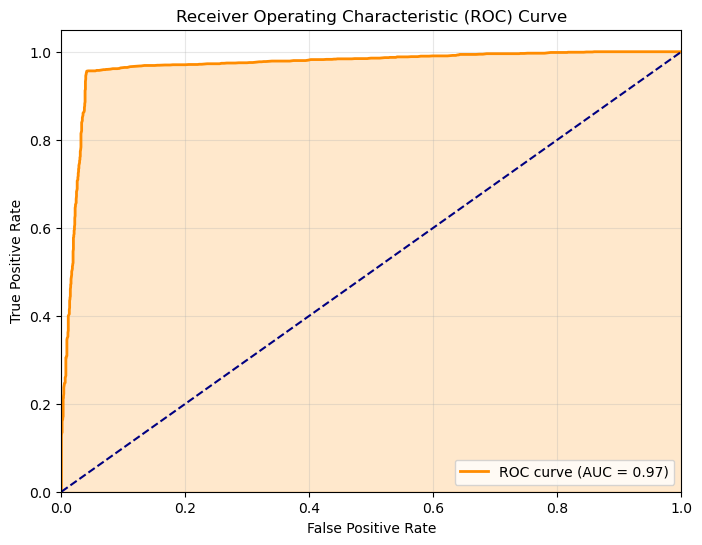

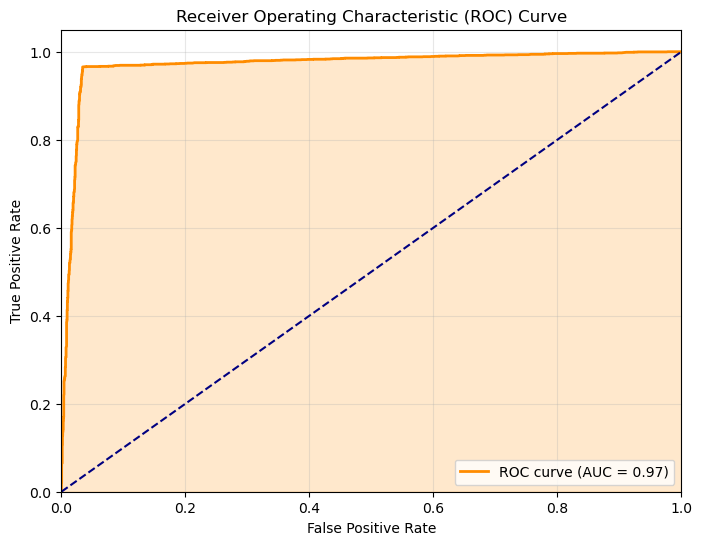

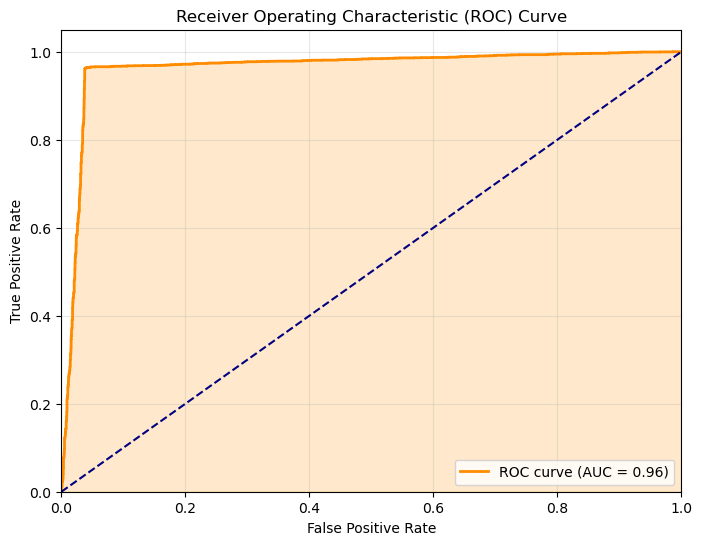

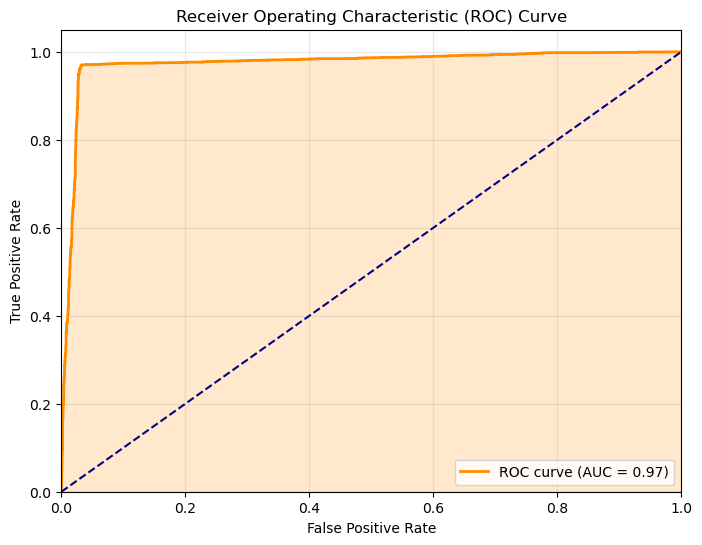

In [64]:
y_true_list = []
y_pred_proba_list = []

for i, dim in enumerate(dimensionality):
	print(f"-=-=-=-= Running {dim} =-=-=-=-")

	X_train = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-X_train.npy')
	X_test = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-X_test.npy')
	y_train = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-y_train.npy')
	y_test = np.load(f'../../Datasets_Train_Test_Split/kryptonite-{dim}-y_test.npy')

	X_train = denoise_bernoulli_data(X_train)
	X_test = denoise_bernoulli_data(X_test)

	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
	best_params = best_params_by_dim[i]
	train_loader = create_dataloaders(X_train, y_train, best_params['batch_size'])
	val_loader = create_dataloaders(X_val, y_val, best_params['batch_size'])
	test_loader = create_dataloaders(X_test, y_test, best_params['batch_size'])
	model = DynamicNeuralNetwork(dim, best_params['hidden_sizes'], 0.15).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=0.0001)
	loss_fn = torch.nn.BCELoss()
	trained_model, _, _, _, _, _ = train_model(model, train_loader, val_loader, loss_fn, optimizer, 200, device)
	test_metrics_run = evaluate_model(trained_model, dim, test_loader, False)

	for metric, value in test_metrics_run.items():
		print(f"{metric.capitalize()}: {value:.4f}")

	predictions = get_predictions_prob(trained_model, test_loader)
	y_true_list.append(predictions['all_labels'])
	y_pred_proba_list.append(predictions['all_predictions'])

	plot_roc_curve(predictions['all_labels'], predictions['all_predictions'])

{9: 0.9679643363325695,
 12: 0.9713818649496249,
 15: 0.963036570482279,
 18: 0.9733334845806102}

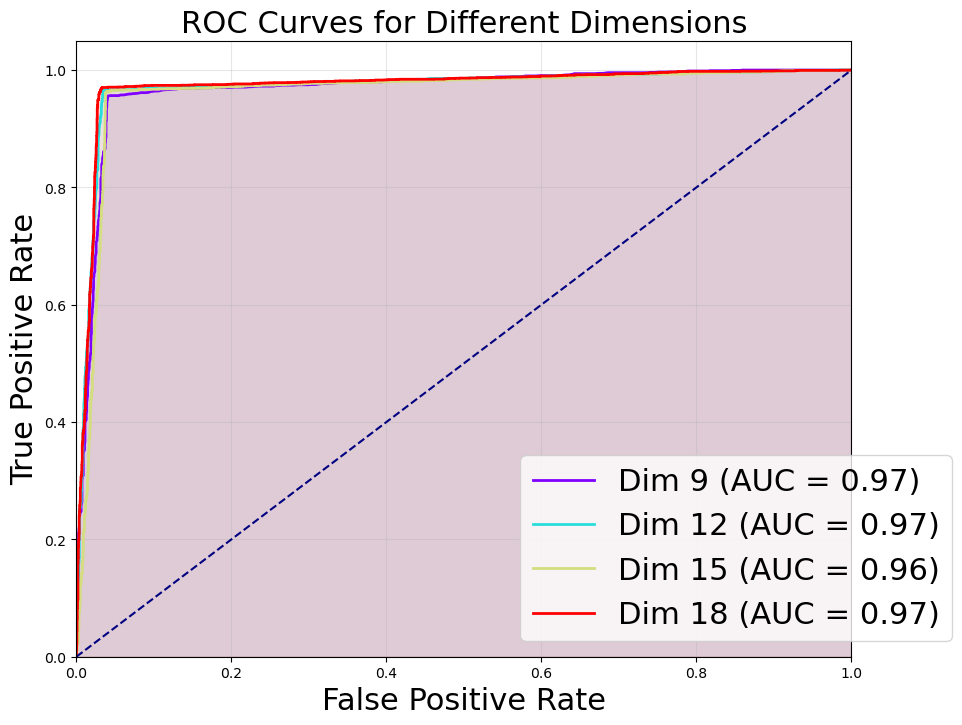

In [65]:
plot_multi_roc_curves(y_true_list, y_pred_proba_list, dimensionality)

# Script to run cross validation

In [69]:
for i, dim in enumerate(dimensionality):
	print(f"-=-=-=-= Running {dim} =-=-=-=-")

	best_params = best_params_by_dim[i]

	X = np.load(f'../../Datasets/kryptonite-{dim}-X.npy')
	y = np.load(f'../../Datasets/kryptonite-{dim}-y.npy')

	X = denoise_bernoulli_data(X)

	# Get both metrics and standard deviations
	avg_metrics, std_metrics = k_fold_cross_validation(X, y, best_params, dim, k=4)

	print("\nFinal K-Fold Cross Validation Results:")
	print(f"Average Accuracy: {avg_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")
	print(f"Average Precision: {avg_metrics['precision']:.4f} ± {std_metrics['precision']:.4f}")
	print(f"Average Recall: {avg_metrics['recall']:.4f} ± {std_metrics['recall']:.4f}")
	print(f"Average F1: {avg_metrics['f1']:.4f} ± {std_metrics['f1']:.4f}")

-=-=-=-= Running 9 =-=-=-=-


100%|██████████| 100/100 [04:35<00:00,  2.75s/it]


[1. 0. 1. ... 1. 0. 1.]


100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


[1. 1. 0. ... 1. 1. 1.]


100%|██████████| 100/100 [04:25<00:00,  2.65s/it]


[0. 1. 0. ... 1. 0. 0.]


100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


[1. 0. 1. ... 0. 0. 1.]

Average Results Across All Folds:
Accuracy: 0.9583 ± 0.0036
Precision: 0.9585 ± 0.0054
Recall: 0.9582 ± 0.0052
F1: 0.9584 ± 0.0044

Final K-Fold Cross Validation Results:
Average Accuracy: 0.9583 ± 0.0036
Average Precision: 0.9585 ± 0.0054
Average Recall: 0.9582 ± 0.0052
Average F1: 0.9584 ± 0.0044
-=-=-=-= Running 12 =-=-=-=-


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


[0. 0. 1. ... 0. 0. 0.]


100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


[0. 0. 0. ... 1. 1. 0.]


100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


[1. 1. 0. ... 1. 1. 1.]


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


[0. 0. 0. ... 0. 1. 1.]

Average Results Across All Folds:
Accuracy: 0.9641 ± 0.0014
Precision: 0.9647 ± 0.0018
Recall: 0.9647 ± 0.0017
F1: 0.9647 ± 0.0012

Final K-Fold Cross Validation Results:
Average Accuracy: 0.9641 ± 0.0014
Average Precision: 0.9647 ± 0.0018
Average Recall: 0.9647 ± 0.0017
Average F1: 0.9647 ± 0.0012
-=-=-=-= Running 15 =-=-=-=-


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


[0. 0. 0. ... 1. 0. 0.]


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


[0. 1. 0. ... 0. 1. 1.]


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


[0. 0. 0. ... 0. 1. 0.]


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


[1. 0. 1. ... 0. 1. 1.]

Average Results Across All Folds:
Accuracy: 0.9647 ± 0.0027
Precision: 0.9630 ± 0.0028
Recall: 0.9666 ± 0.0028
F1: 0.9648 ± 0.0027

Final K-Fold Cross Validation Results:
Average Accuracy: 0.9647 ± 0.0027
Average Precision: 0.9630 ± 0.0028
Average Recall: 0.9666 ± 0.0028
Average F1: 0.9648 ± 0.0027
-=-=-=-= Running 18 =-=-=-=-


100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


[1. 0. 1. ... 0. 0. 0.]


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


[0. 1. 0. ... 1. 1. 1.]


100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


[1. 0. 1. ... 1. 1. 0.]


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

[1. 0. 1. ... 0. 0. 1.]

Average Results Across All Folds:
Accuracy: 0.9462 ± 0.0316
Precision: 0.9503 ± 0.0264
Recall: 0.9419 ± 0.0375
F1: 0.9460 ± 0.0318

Final K-Fold Cross Validation Results:
Average Accuracy: 0.9462 ± 0.0316
Average Precision: 0.9503 ± 0.0264
Average Recall: 0.9419 ± 0.0375
Average F1: 0.9460 ± 0.0318


# Getting the predicitons of the hidden data up to 18 dimesnions

In [70]:
dimensionality = [9, 12, 15, 18]

for i, dim in enumerate(dimensionality):
	print(f"-=-=-=-= Running {dim} =-=-=-=-")
	X = np.load(f'..\..\Datasets\kryptonite-{dim}-X.npy')
	y = np.load(f'..\..\Datasets\kryptonite-{dim}-y.npy')

	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

	X_train = np.array(denoise_bernoulli_data(X_train))
	X_val = np.array(denoise_bernoulli_data(X_val))

	best_params = best_params_by_dim[i]

	# Convert to PyTorch tensors
	X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
	y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
	X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
	y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

	# Create data loaders
	train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
	val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
	train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

	# Initialize and train model
	model = DynamicNeuralNetwork(dim, best_params['hidden_sizes'], 0.15).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=0.0001)
	loss_fn = torch.nn.BCELoss()
	trained_model, _, _, _, _, _ = train_model(model, train_loader, val_loader, loss_fn, optimizer, 200, device)

	X = np.load(f'..\..\Datasets\hidden-kryptonite-{dim}-X.npy')
	X = denoise_bernoulli_data(X)
	X = torch.tensor(X, dtype=torch.float32).to(device)
    
	predict_dataset = TensorDataset(X)
	predict_loader = DataLoader(predict_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
	predictions = get_predictions_final(model, predict_loader)
	np.save(f'nn_predictions_{dim}.npy', predictions)

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:33: SyntaxWarning: invalid escape sequence '\.'
C:\Users\migue\AppData\Local\Temp\ipykernel_20368\2452398718.py:5: SyntaxWarning: invalid escape sequence '\.'
  X = np.load(f'..\..\Datasets\kryptonite-{dim}-X.npy')
C:\Users\migue\AppData\Local\Temp\ipykernel_20368\2452398718.py:6: SyntaxWarning: invalid escape sequence '\.'
  y = np.load(f'..\..\Datasets\kryptonite-{dim}-y.npy')
C:\Users\migue\AppData\Local\Temp\ipykernel_20368\2452398718.py:33: SyntaxWarning: invalid escape sequence '\.'
  X = np.load(f'..\..\Datasets\hidden-kryptonite-{dim}-X.npy')


-=-=-=-= Running 9 =-=-=-=-


100%|██████████| 200/200 [09:04<00:00,  2.72s/it]


[0. 1. 0. ... 1. 1. 1.]
-=-=-=-= Running 12 =-=-=-=-


100%|██████████| 200/200 [05:36<00:00,  1.68s/it]


[0. 0. 1. ... 1. 1. 0.]
-=-=-=-= Running 15 =-=-=-=-


100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


[0. 1. 1. ... 1. 1. 0.]
-=-=-=-= Running 18 =-=-=-=-


100%|██████████| 200/200 [04:42<00:00,  1.41s/it]

[1. 0. 0. ... 0. 1. 1.]


# Getting the predicitons of the hidden data dim > 18

In [75]:
dimensionality = [24, 30, 45]

for i, dim in enumerate(dimensionality):
	print(f"-=-=-=-= Running {dim} =-=-=-=-")
	X = np.load(rf'..\..\Datasets\kryptonite-{dim}-X.npy')
	y = np.load(rf'..\..\Datasets\kryptonite-{dim}-y.npy')

	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

	X_train = np.array(denoise_bernoulli_data(X_train))
	X_val = np.array(denoise_bernoulli_data(X_val))

	best_params = best_params_by_dim[3] # The best parameter for dim = 18 is used for the higher dimensions

	# Convert to PyTorch tensors
	X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
	y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
	X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
	y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

	# Create data loaders
	train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
	val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
	train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

	# Initialize and train model
	model = DynamicNeuralNetwork(dim, best_params['hidden_sizes'], 0.15).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=0.0001)
	loss_fn = torch.nn.BCELoss()
	trained_model, _, _, _, _, _ = train_model(model, train_loader, val_loader, loss_fn, optimizer, 200, device)

	X = np.load(rf'..\..\Datasets\hidden-kryptonite-{dim}-X.npy')
	X = denoise_bernoulli_data(X)
	X = torch.tensor(X, dtype=torch.float32).to(device)
    
	predict_dataset = TensorDataset(X)
	predict_loader = DataLoader(predict_dataset, batch_size=best_params['batch_size'], shuffle=False)
    
	predictions = get_predictions_final(model, predict_loader)
	np.save(f'nn_predictions_{dim}.npy', predictions)

-=-=-=-= Running 24 =-=-=-=-


100%|██████████| 200/200 [08:16<00:00,  2.48s/it]


[0. 1. 0. ... 0. 1. 1.]
-=-=-=-= Running 30 =-=-=-=-


100%|██████████| 200/200 [08:44<00:00,  2.62s/it]


[0. 0. 0. ... 0. 0. 0.]
-=-=-=-= Running 45 =-=-=-=-


100%|██████████| 200/200 [13:54<00:00,  4.17s/it]

[1. 1. 1. ... 1. 1. 1.]
